In [1]:
import time
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pickle

def load_data( seq_len, normalise_window):
   
    data=pickle.load(open('processed_data.p', "rb" ))
    
    seat_data=data.loc[data['seatName']=='B5_9_1_05']
    seat_data=seat_data.sort_values(['Datetime'])
    seat_data=seat_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
    seat_data.set_index('Datetime',inplace=True)
    trial_data=np.array(seat_data['Space'])
    
    print(trial_data)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(trial_data) - sequence_length):
        result.append(trial_data[index: index + sequence_length])

    result = np.array(result)

    row = round(0.85 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    
    x_test_date = seat_data.tail(len(x_test)).index
    
    return [x_train, y_train, x_test, y_test,x_test_date]

def build_model(layers):
    model = Sequential()

    model.add(CuDNNLSTM( input_shape=(layers[1], layers[0]), units=layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(CuDNNLSTM(units=layers[2]))
    model.add(Dropout(0.2))
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("sigmoid"))

    start = time.time()
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

C:\Users\ndrs\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
def loss_plot(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show();
    
def acc_plot(history):
    pyplot.plot(history.history['acc'], label='train_acc')
    pyplot.plot(history.history['val_acc'], label='test_acc')
    pyplot.legend()
    pyplot.show();
    
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show();

def plot_results_multiple(predicted_data, true_data,x_test_date, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show();

#Main Run Thread
if __name__=='__main__':
    global_start_time = time.time()
    epochs  = 50
    seq_len = 50
    #lstm_dim=50
    lstm_dim2=100
    batch_size=100
    print('> Loading data... ')

    X_train, y_train, X_test, y_test,x_test_date = load_data( seq_len, True)

    print('> Data Loaded. Compiling...')

    model = build_model([1, seq_len, lstm_dim2, 1])

    history=model.fit( X_train,y_train,batch_size=batch_size,shuffle=False,nb_epoch=epochs,validation_split=0.10)

    predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
    #predictions = predict_sequence_full(model, X_test, seq_len)
    #predictions = predict_point_by_point(model, X_test)        

    print('Training duration (s) : ', time.time() - global_start_time)

> Loading data... 
[0 0 0 ... 0 0 0]
> Data Loaded. Compiling...
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\Users\ndrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
C:\Users\ndrs\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


> Compilation Time :  0.05717325210571289
Train on 3375 samples, validate on 376 samples
Epoch 1/50
3375/3375 [==============================] - 3s 946us/step - loss: 0.3867 - acc: 0.8785 - val_loss: 0.2973 - val_acc: 0.8750
Epoch 2/50
3375/3375 [==============================] - 0s 106us/step - loss: 0.2237 - acc: 0.9070 - val_loss: 0.2445 - val_acc: 0.8989
Epoch 3/50
3375/3375 [==============================] - 0s 108us/step - loss: 0.2047 - acc: 0.9153 - val_loss: 0.2265 - val_acc: 0.9016
Epoch 4/50
3375/3375 [==============================] - 0s 105us/step - loss: 0.1937 - acc: 0.9161 - val_loss: 0.2191 - val_acc: 0.9122
Epoch 5/50
3375/3375 [==============================] - 0s 102us/step - loss: 0.1876 - acc: 0.9179 - val_loss: 0.2150 - val_acc: 0.9176
Epoch 6/50
3375/3375 [==============================] - 0s 100us/step - loss: 0.1852 - acc: 0.9203 - val_loss: 0.2110 - val_acc: 0.9149
Epoch 7/50
3375/3375 [==============================] - 0s 100us/step - loss: 0.1799 - acc: 0.9

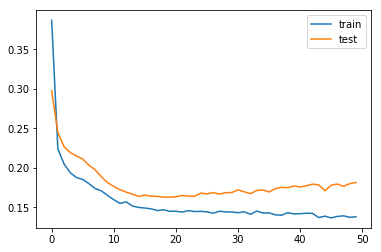

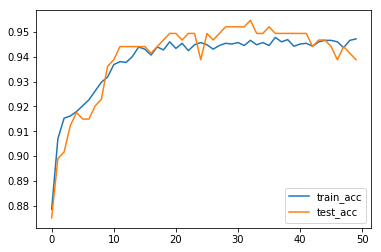

In [3]:
loss_plot(history)
acc_plot(history)

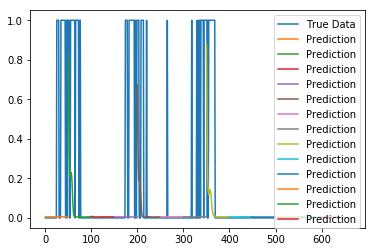

In [4]:
plot_results_multiple(predictions, y_test,x_test_date, seq_len)

In [24]:
#plot_results(predictions,y_test)